In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'v' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 5 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/2/21 1D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/2/21 1D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/2/21 1D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/2/21 1D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/2/21 1D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/2/21 1D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/2/21 1D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/2/21 1D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/2/21 1D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/2/21 1D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/2/21 1D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/2/21 1D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/2/21 1D, 5D ahead
               , 'msft': '03/10/1986' # Updated 1/2/21 1D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/2/21 1D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/2/21 1D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/2/21 1D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 1/2/21 1D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/2/21 1D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/1/21
               , 'vgt': '01/26/2004' # Updated 1/1/21
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,211.779999,208.850006,209.000000,211.179993,6517200.0,211.179993,-0.010431,0.014029,0.013972,0.007624,0.003439,1
2020-12-18,211.979996,209.869995,211.020004,211.309998,13298200.0,211.309998,-0.001374,0.010054,0.000616,0.005685,0.004882,1
2020-12-21,209.800003,204.789993,208.270004,209.009995,7576700.0,209.009995,-0.003553,0.024464,-0.010884,0.009056,0.001725,1
2020-12-22,208.399994,205.600006,208.389999,205.839996,7396200.0,205.839996,0.012237,0.013619,-0.015167,0.011358,-0.002379,1
2020-12-23,207.330002,205.110001,207.330002,205.300003,6523100.0,205.300003,0.009791,0.010823,-0.002623,0.011306,-0.002817,1
2020-12-24,208.820007,206.600006,206.639999,208.699997,3367900.0,208.699997,-0.009969,0.010745,0.016561,0.012284,-0.002300,-1
2020-12-28,213.460007,208.949997,209.850006,212.630005,5816200.0,212.630005,-0.013248,0.021584,0.018831,0.015614,0.001343,-1
2020-12-29,215.240005,213.539993,214.610001,214.369995,6093400.0,214.369995,0.001118,0.007961,0.008183,0.014140,0.005157,-1
2020-12-30,220.389999,215.649994,216.000000,218.360001,8875100.0,218.360001,-0.010926,0.021980,0.018613,0.009214,0.011913,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.71144659 0.71144659 0.71144659]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

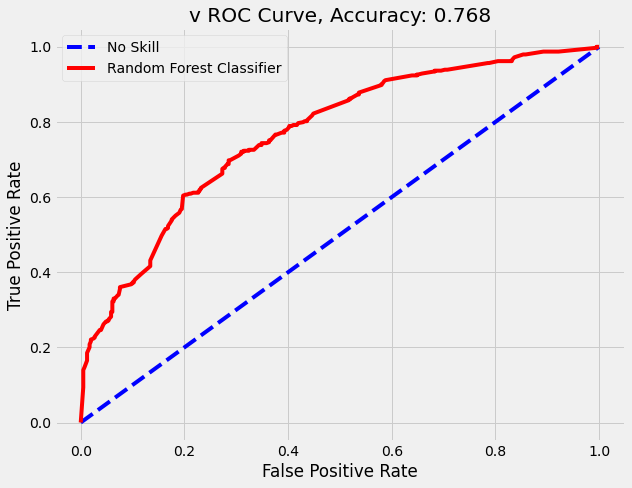

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

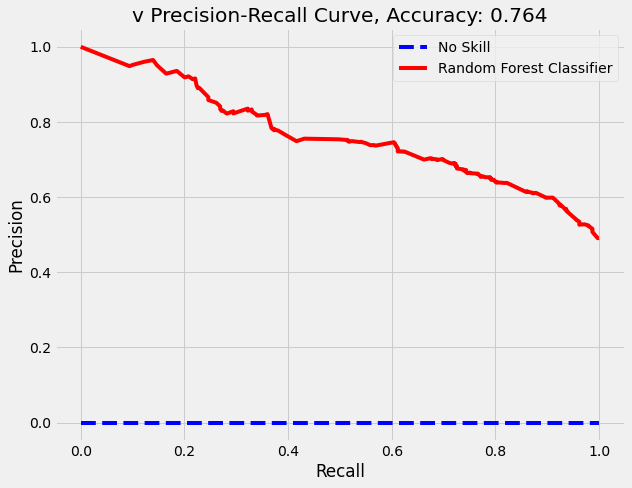

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

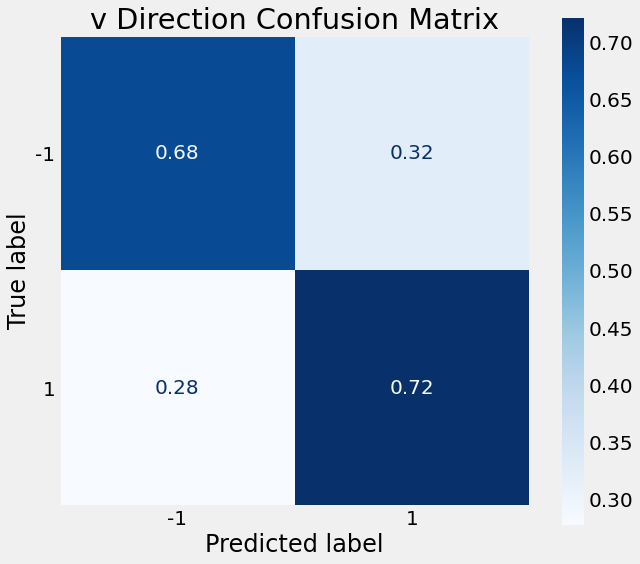

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7027278962162998'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.198200e+02
Low           2.162000e+02
Open          2.184000e+02
Close         2.187300e+02
Volume        5.921300e+06
Adj Close     2.187300e+02
oc           -1.510997e-03
hl            1.674380e-02
adj           1.694427e-03
5stdev_adj    7.565565e-03
5sma_adj      1.277646e-02
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.001511
hl            0.016744
5stdev_adj    0.007566
5sma_adj      0.012776
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    3216.000000
mean        0.001022
std         0.018995
min        -0.136434
25%        -0.007634
50%         0.001292
75%         0.009494
max         0.149974
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold v


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,208.820007,206.600006,206.639999,208.699997,3367900.0,208.699997,-0.009969,0.010745,0.016561,0.012284,-0.002300,-1,-1,-0.018831
2020-12-28,213.460007,208.949997,209.850006,212.630005,5816200.0,212.630005,-0.013248,0.021584,0.018831,0.015614,0.001343,-1,-1,-0.008183
2020-12-29,215.240005,213.539993,214.610001,214.369995,6093400.0,214.369995,0.001118,0.007961,0.008183,0.014140,0.005157,-1,1,0.018613
2020-12-30,220.389999,215.649994,216.000000,218.360001,8875100.0,218.360001,-0.010926,0.021980,0.018613,0.009214,0.011913,-1,-1,-0.001694
2020-12-31,219.820007,216.199997,218.399994,218.729996,5921300.0,218.729996,-0.001511,0.016744,0.001694,0.007566,0.012776,-1,-1,-0.001292


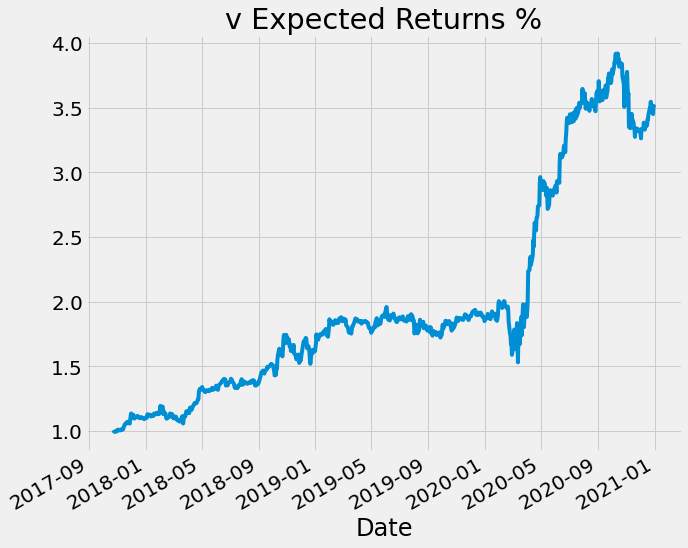

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.8678071423807823

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

10.056742237816325

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/